In [1]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential


import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!7z x /content/drive/MyDrive/CLAHE_new.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 319352072 bytes (305 MiB)

Extracting archive: /content/drive/MyDrive/CLAHE_new.zip
 27% 4096 Open               54% 8192 Open              --
Path = /content/drive/MyDrive/CLAHE_new.zip
Type = zip
Physical Size = 319352072

  0%      3% 514 - CLAHE_new/1/14397_left.jpeg                                        5% 873 - CLAHE_new/1/26190_right.jpeg                                         8% 1183 - CLAHE_new/1/

In [4]:
import pathlib
data_dir = '/content/CLAHE_new'
data_dir = pathlib.Path(data_dir)

In [5]:
from pathlib import Path
import imghdr

In [6]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

15152


In [7]:
batch_size = 16
img_height = 256
img_width = 256

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True, #to select random image
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 15152 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
print(class_names)

['0', '1']


In [10]:
#training images
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15152 files belonging to 2 classes.
Using 10607 files for training.


In [11]:
#testing images
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15152 files belonging to 2 classes.
Using 4545 files for validation.


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5, seed=None),
    layers.RandomCrop(150, 150, seed=None)
  ]
)

In [12]:
number_classes = len(class_names)

from keras.layers import  Dropout, BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

model = models.Sequential([
        layers.Conv2D(32, (3,3), input_shape=(256,256,3), strides=(1, 1), activation='relu',padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Conv2D(64, (5, 5), activation='relu', strides=(1, 1), padding='valid'),
        layers.MaxPool2D(pool_size=(4, 4), padding='valid'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(32, activation='relu'),
        layers.Dense(number_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0

In [13]:
import time
start_cnn = time.time()

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_den.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=5)

callback_list = [checkpoint,es]

In [16]:
#model compilation
model.compile(optimizer= 'Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback_list
)

Epoch 1/50
663/663 [==============================] - ETA: 0s - loss: 1.0847 - accuracy: 0.6028
Epoch 1: val_accuracy improved from -inf to 0.65985, saving model to best_model_den.hdf5
663/663 [==============================] - 49s 60ms/step - loss: 1.0847 - accuracy: 0.6028 - val_loss: 0.6627 - val_accuracy: 0.6598
Epoch 2/50
662/663 [============================>.] - ETA: 0s - loss: 0.6682 - accuracy: 0.6489
Epoch 2: val_accuracy improved from 0.65985 to 0.66139, saving model to best_model_den.hdf5
663/663 [==============================] - 39s 59ms/step - loss: 0.6682 - accuracy: 0.6488 - val_loss: 0.6444 - val_accuracy: 0.6614
Epoch 3/50
662/663 [============================>.] - ETA: 0s - loss: 0.6490 - accuracy: 0.6562
Epoch 3: val_accuracy did not improve from 0.66139
663/663 [==============================] - 38s 57ms/step - loss: 0.6489 - accuracy: 0.6565 - val_loss: 0.6456 - val_accuracy: 0.6614
Epoch 4/50
663/663 [==============================] - ETA: 0s - loss: 0.6434 - ac

In [18]:
scores = model.evaluate(train_ds)

663/663 [==============================] - 14s 20ms/step - loss: 0.6413 - accuracy: 0.6594


In [19]:
scores = model.evaluate(val_ds)

285/285 [==============================] - 6s 20ms/step - loss: 0.6408 - accuracy: 0.6614


Text(0.5, 1.0, 'Training and Validation Accuracy')

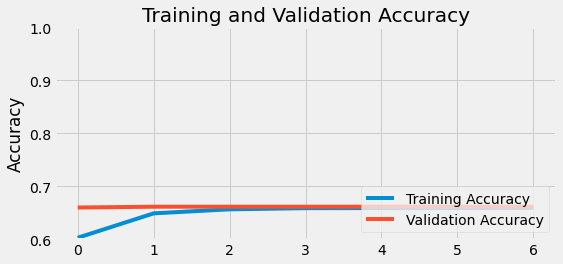

In [20]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


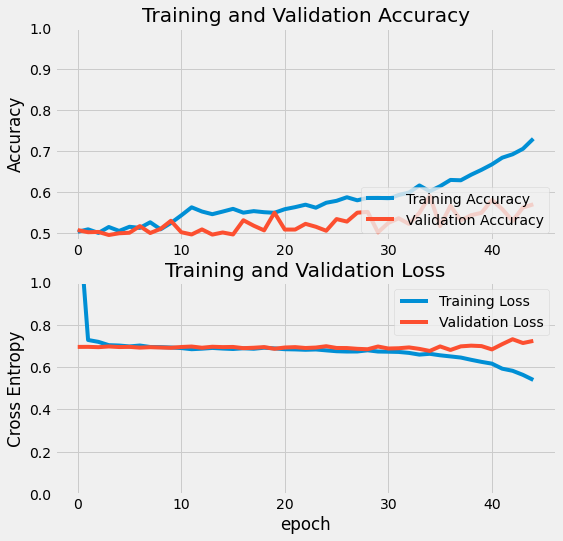

In [ ]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list) 

In [22]:
x = np.array(X)

In [23]:
y = np.array(y)

In [24]:
x.shape

(1536, 256, 256, 3)

In [25]:
y.shape

(1536,)

In [31]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:1500])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:1500], y_pred_classes))

47/47 [==============================] - 1s 24ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.66      1.00      0.79       988
           1       0.00      0.00      0.00       512

    accuracy                           0.66      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.43      0.66      0.52      1500



Text(0.5, 1.0, 'Training and Validation Accuracy')

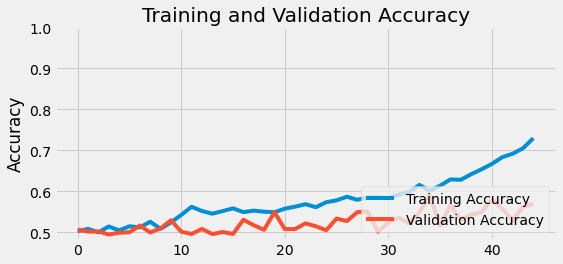

In [ ]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


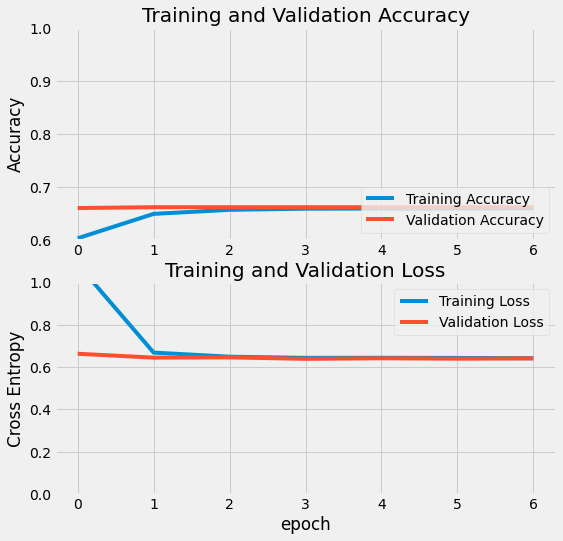

In [27]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()